In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import os
import json
import random
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [3]:
def readData():
    dataFolder = "./data/"
    files = os.listdir(dataFolder)
    data = []
    for file in files:
        path = dataFolder + file
        with open(path, "r") as f:
            raw = f.read()
            raw = raw.split("\n")
            for singleRaw in raw[:-1]:
                datapoint = json.loads(singleRaw)
                readings = datapoint["data"]
                hz = len(readings) / ((readings[-1][0] - readings[0][0]) * 10**-9)  # timestamp is in nanoseconds
                if (hz > 40):
                    data += [datapoint]
    return data

data = readData()

In [4]:

def normalise(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset-mu) / sigma

def convertData(data):
    X, T, truth, misc = [], [], [], []
    for d in data:
        id = d["id"]
        drunk = d["drunk"]
        walking = d["walking"]
        readings = d["data"]
        firstTimestamp = readings[0][0]
        convertedReadings = []
        timestamps = []
        for r in readings:
            t, x, y, z = r
            timestamp = t - firstTimestamp  # slide so all timestamps start at 0
            if timestamp < 30 * 10**9 and len(convertedReadings)<1200:
                convertedReadings += [ [x, y, z] ]
                timestamps += [t]
            if timestamp < 0:
                break
        else:
            if len(convertedReadings) == 1200:
                X += [normalise(np.array(convertedReadings))]
                T += [timestamps]
                truth += [drunk]
                misc += [id, walking]
    X = np.array(X)
    T = np.array(T)
    truth = np.array(truth).astype(int)
    truthOnehot = np.zeros((truth.size, 2))
    truthOnehot[np.arange(truth.size), truth] = 1
    misc = np.array(misc)
    return X, T, truthOnehot, misc



X, T, y, misc = convertData(data)

In [5]:
def getTrainTestSplit(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = getTrainTestSplit(X, y)


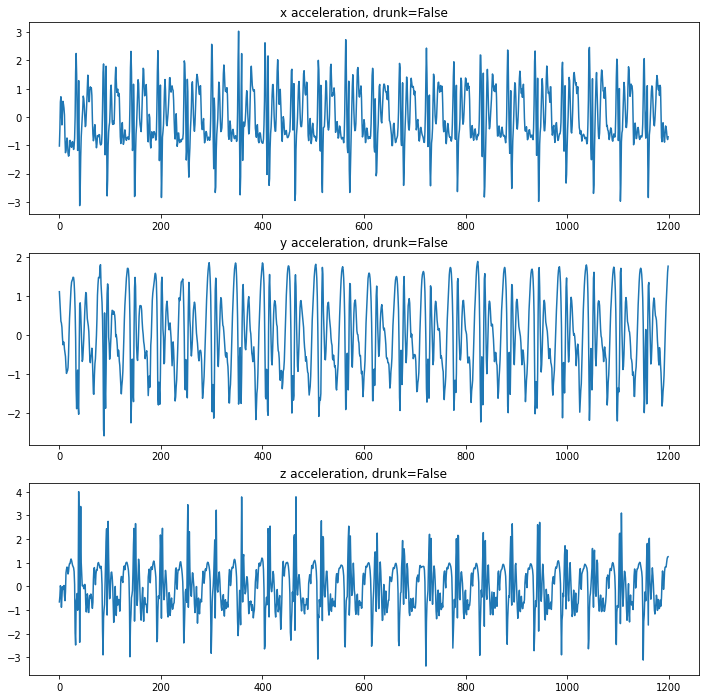

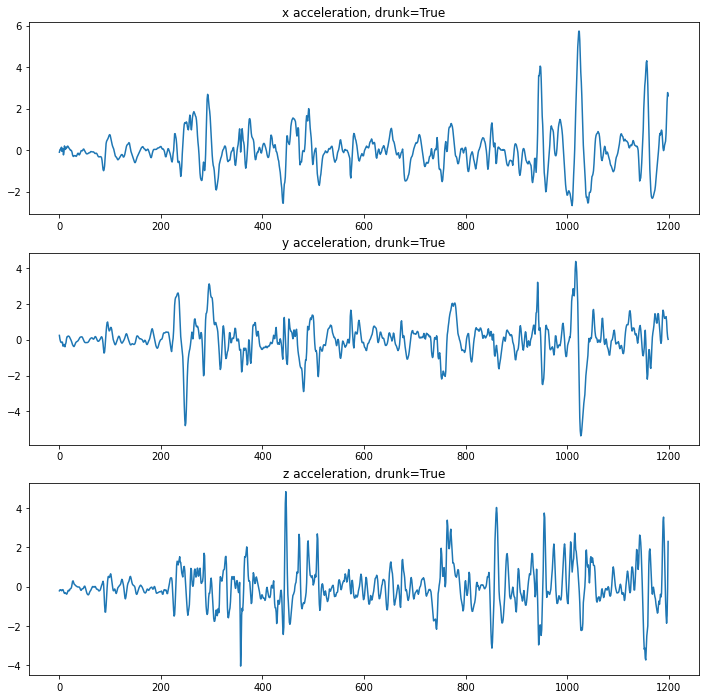

In [15]:
def plot(axes, x, drunk):
    for ax, vals, label in zip(axes, x.T, "xyz"):
        ax.plot([i for i in range(len(vals))], vals)
        ax.set_title(f"{label} acceleration, drunk={drunk}")
    #ax.title = title

def plotdata(X, T, y):
    for option in range(y.shape[1]):
        series = random.choice(X[y.T[option]==1])
        fig, axes = plt.subplots(nrows=3, figsize=(12,12))
        plot(axes, series, option==1)

plotdata(X, T, y)



In [8]:
def trainModel(X, y):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X.shape[1], X.shape[2])))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X, y, epochs=6, batch_size=32)

    return model

In [12]:
def trainModels(X, y, repeats=10):
	# repeat experiment
	models = []
	for i in range(repeats):
		print(f"> test {i}")
		model = trainModel(X, y)
		models.append(model)
	return models

def predictTestData(models, X_test):
	predictions = []
	for i, m in enumerate(models):
		y_pred = m.predict(X_test)
		y_pred = y_pred.round()
		predictions.append(y_pred)
	return predictions

def evaluatePredictions(predictions, y):
	for i, y_pred in enumerate(predictions):
		accuracy = metrics.accuracy_score(y, y_pred)
		precision = metrics.precision_score(y, y_pred, average="macro")
		recall = metrics.recall_score(y, y_pred, average="macro")
		
		scores.append([accuracy, precision, recall])
	return scores
# run the experiment
models = trainModels(X_train, y_train)
predictions = predictTestData(models, X_test)
scores = evaluatePredictions(predictions, y_test)

> test 0
Epoch 1/6
10/10 [==============================] - 2s 154ms/step - loss: 2.1030 - accuracy: 0.5049
Epoch 2/6
10/10 [==============================] - 2s 163ms/step - loss: 0.6502 - accuracy: 0.6149
Epoch 3/6
10/10 [==============================] - 2s 165ms/step - loss: 0.6139 - accuracy: 0.6343
Epoch 4/6
10/10 [==============================] - 2s 163ms/step - loss: 0.5423 - accuracy: 0.7961
Epoch 5/6
10/10 [==============================] - 2s 162ms/step - loss: 0.3910 - accuracy: 0.8900
Epoch 6/6
10/10 [==============================] - 2s 206ms/step - loss: 0.2207 - accuracy: 0.9191
> test 1
Epoch 1/6
10/10 [==============================] - 3s 201ms/step - loss: 2.3388 - accuracy: 0.4887
Epoch 2/6
10/10 [==============================] - 1s 145ms/step - loss: 0.6121 - accuracy: 0.6278
Epoch 3/6
10/10 [==============================] - 2s 177ms/step - loss: 0.5054 - accuracy: 0.8188
Epoch 4/6
10/10 [==============================] - 2s 170ms/step - loss: 0.3686 - accuracy:

In [18]:
def summarize_results(scores):
	s = np.array(scores)
	#m, s = np.mean(scores), np.std(scores)
	chosenMetrics = ["accuracy ", 
					 "precision", 
					 "recall   "]
	mean = s.mean(axis=0)
	std = s.std(axis=0)
	for m, v, d in zip(chosenMetrics, mean, std):
		print(f"{m}: {v :.3f} (+- {d :.3f})")
	#print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

summarize_results(scores)

accuracy : 0.851 (+- 0.049)
precision: 0.863 (+- 0.033)
recall   : 0.846 (+- 0.049)


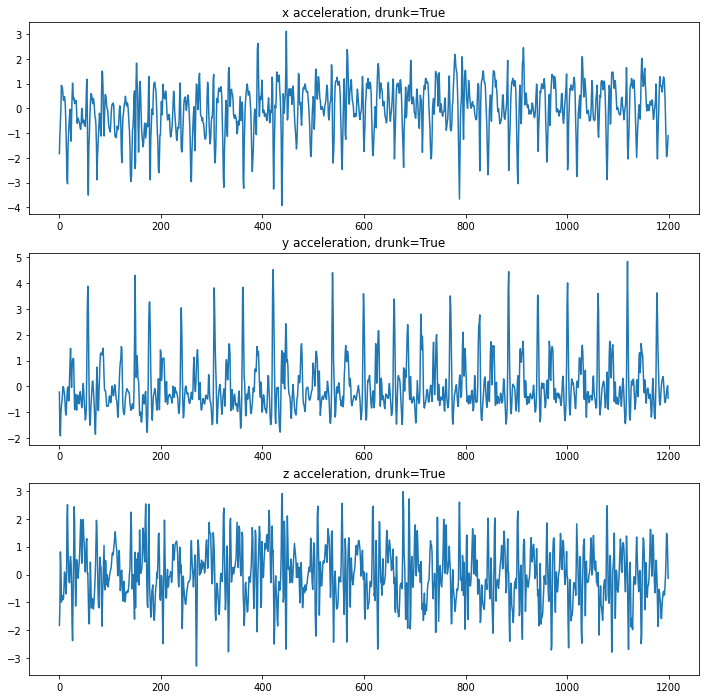

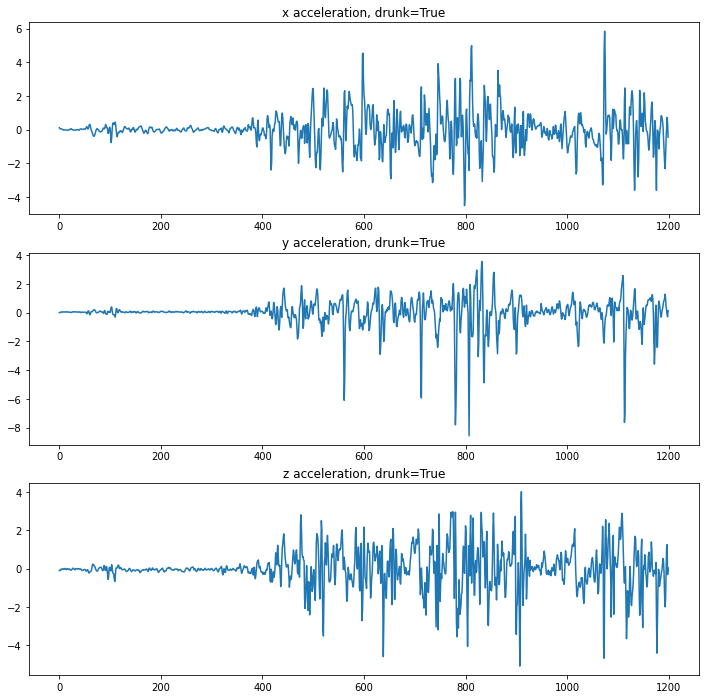

In [30]:
def getFalseNegatives(X, prediction, y):
    grndPositives = y.T[0] == 1
    predNegatives = prediction.T[1] == 1
    falseNegatives = np.logical_and(grndPositives, predNegatives)
    return X[falseNegatives]

falseNegatives = getFalseNegatives(X_test, predictions[0], y_test)


for n in falseNegatives:
    fig, axes = plt.subplots(nrows=3, figsize=(12,12))
    plot(axes, n, True)

10


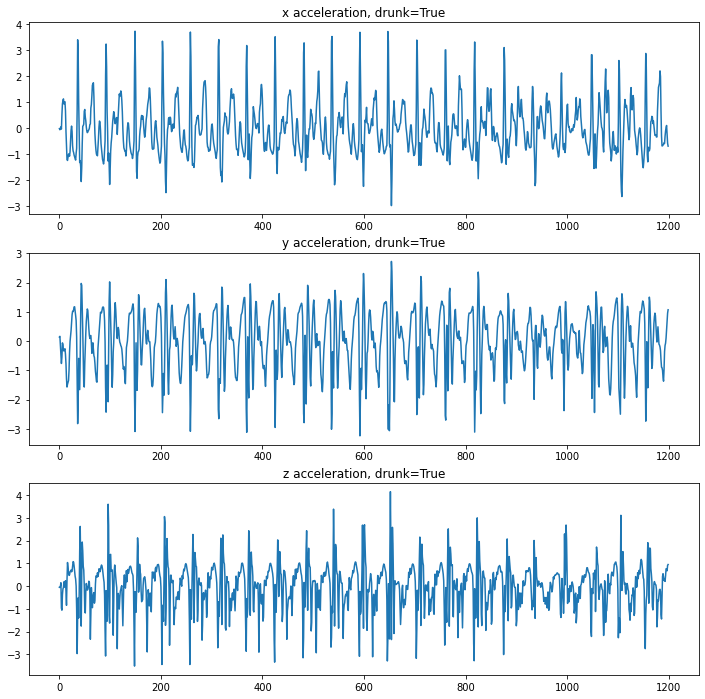

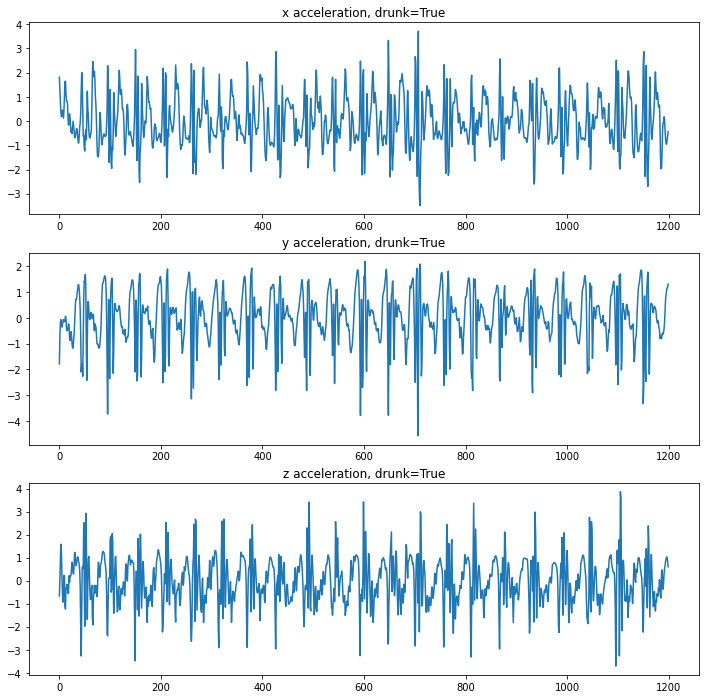

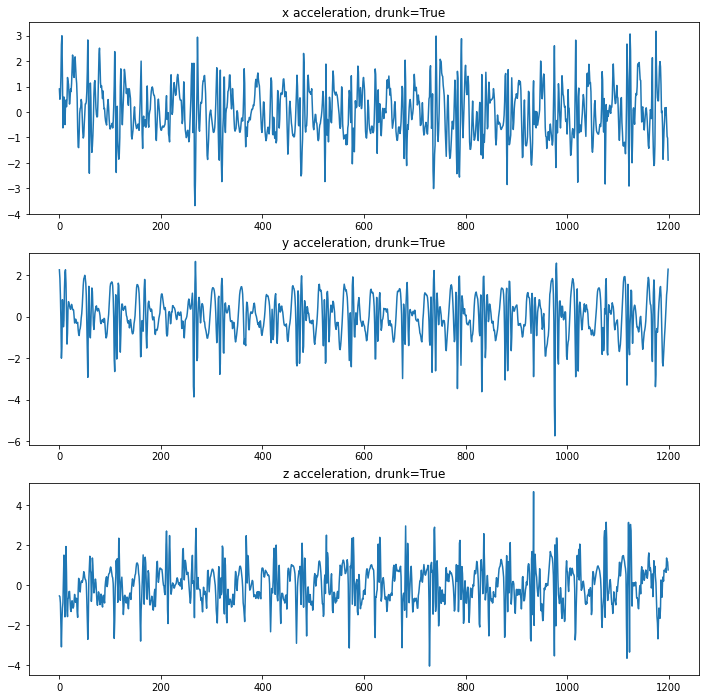

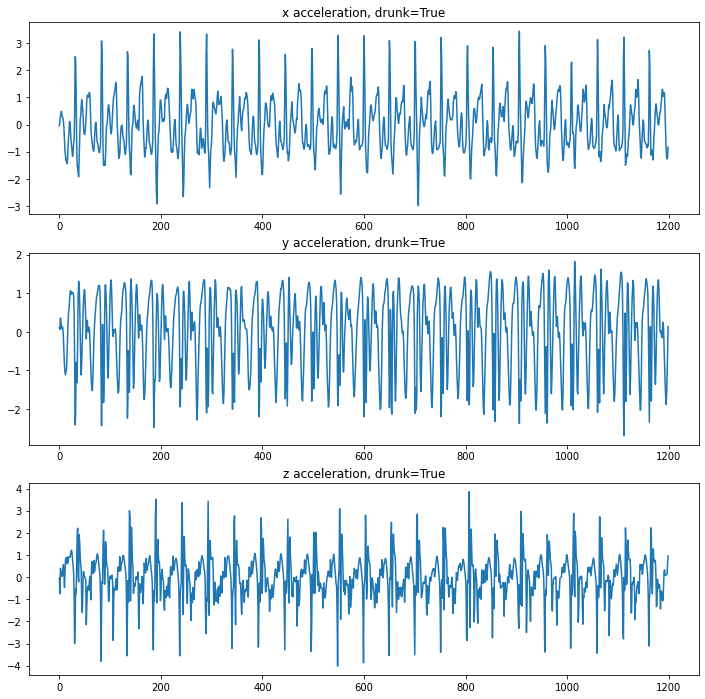

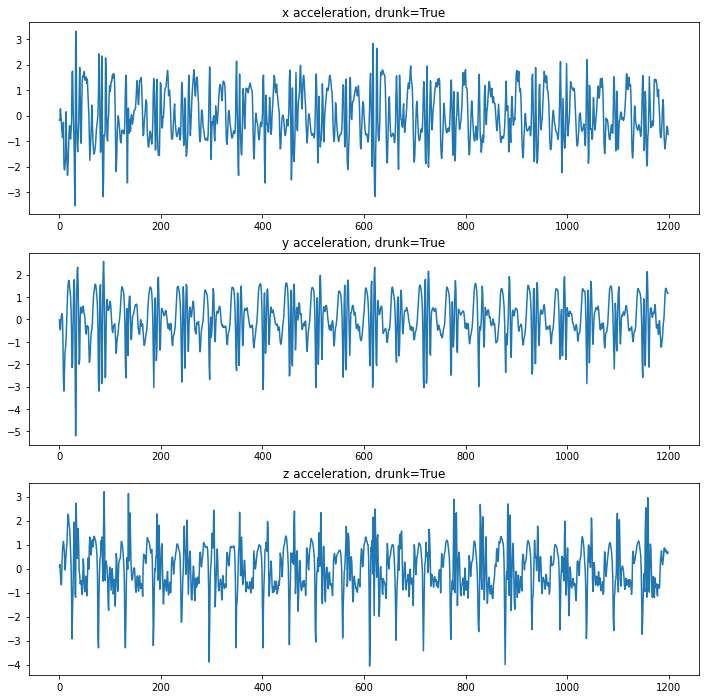

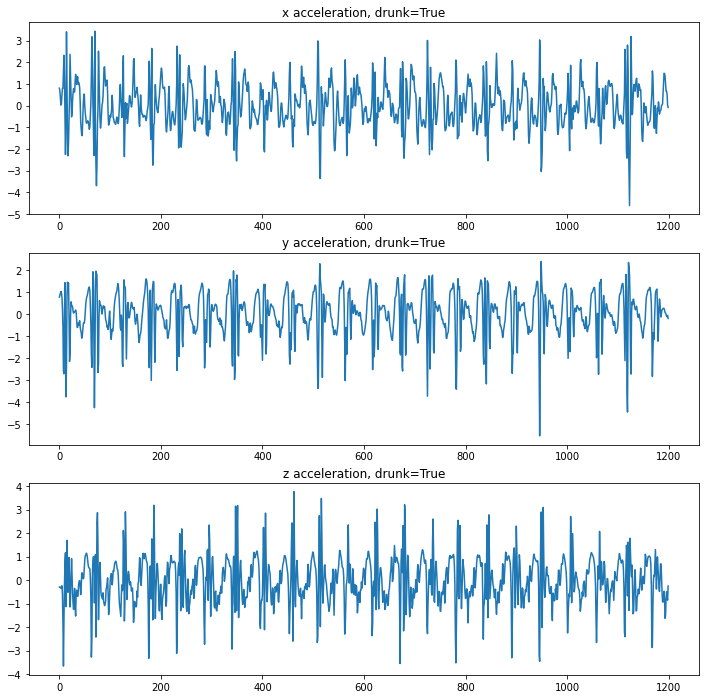

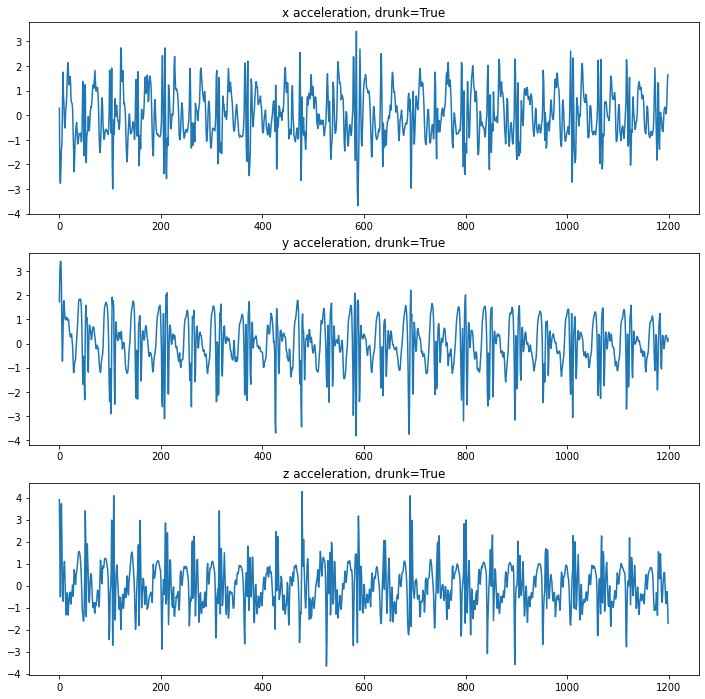

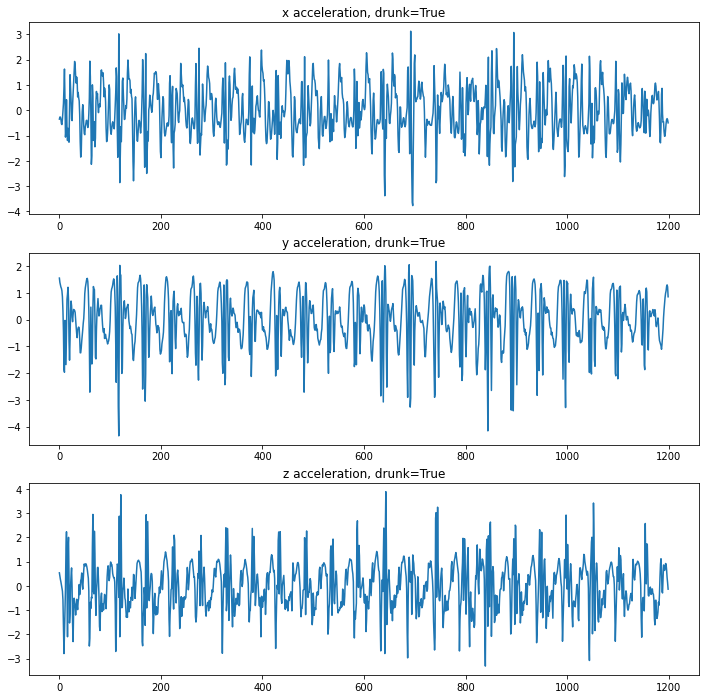

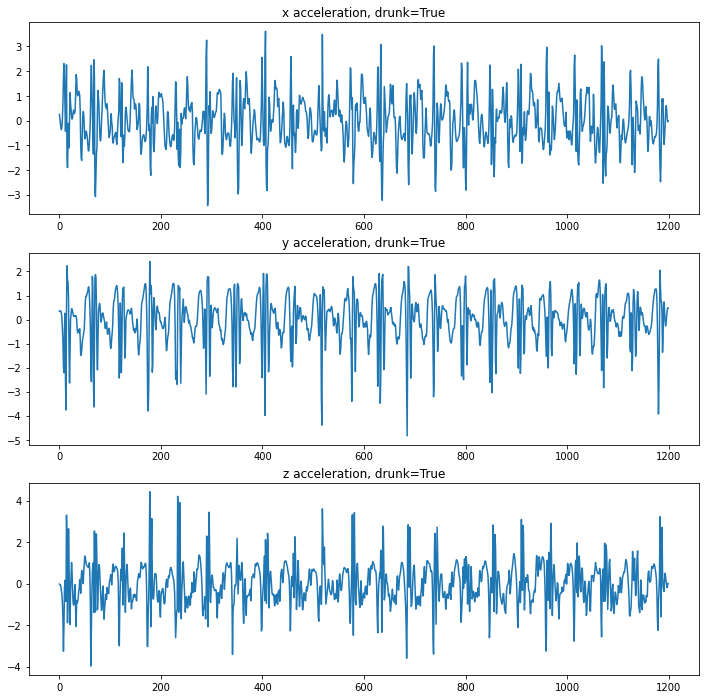

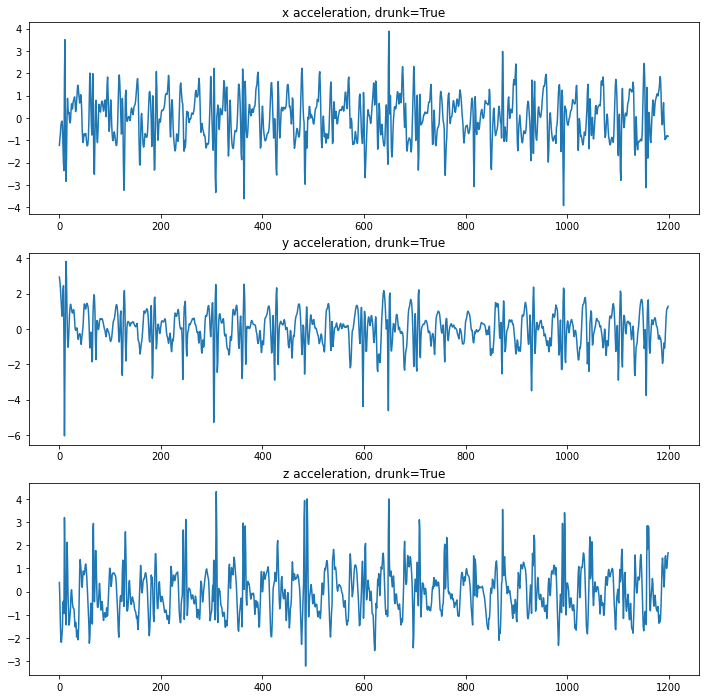

In [32]:
def getFalsePosetives(X, prediction, y):
    grndNegatives = y.T[1] == 1
    predPositives = prediction.T[0] == 1
    falsePosetives = np.logical_and(grndNegatives, predPositives)
    return X[falsePosetives]

falsePosetives = getFalsePosetives(X_test, predictions[0], y_test)
print(len(falsePosetives))

for n in falsePosetives:
    fig, axes = plt.subplots(nrows=3, figsize=(12,12))
    plot(axes, n, True)